# Handwritten Digit Recognition

This tutorial guides you through implementing a classic computer vision application: identifying handwritten digits with neural networks. 
    
## Learning points
1. How to prepare image data for training?
    * batching and color channels
    * 2d or 4d tensors for raw image data
2. How to use a high-level framework (MXNet/Gluon) to create a neural model?
    * fully-connected and convolution layers
    * stacking layers
3. How to train the model?
    * typical training loop
    * model evaluation
    
## Note about neural nets architecture and MXNet API

A good source to learn more about why we design neural nets the way we do, and the rationale behind various layers is 
[Stanford cs231n class](https://cs231n.github.io/).

To learn more about MXNet Gluon API, check out
[Deep Learning --- The Straight Dope](http://gluon.mxnet.io/index.html)

## Prepare data

We first download the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a commonly used dataset for handwritten digit recognition.

* Each image in this dataset has been center-cropped to 28x28 with grayscale pixel value [0, 255].
* Each image has only a single color channel, rather than three channels as for RGB images.
* There are two separate sets of files. The training set contains 60000 examples, and the test set 10000 examples.
* Each example includes an image and a label.

See more details about the dataset at http://yann.lecun.com/exdb/mnist/.

### 2d and 4d tensors for raw images

You are familiar with images being stored as a 2d matrix, (width, height). For an image with multiple color channels, you can use a 3d tensor (color_channel, width, height).

If we have a bunch of images, we can use 4d tensors to represent them, by adding a new batch_size dimension,

**(batch_size, color_channel, width, height)**

For example, the grayscale digit image (28, 28) can be stored in memory as (1, 28, 28), and a batch of 100 images can be stored as a **(100, 1, 28, 28)** tensor. 
    
This 4d tensor format for raw images would be later used as input to convolution layer.

An alternative way to represent the raw images is to flatten all the dimensions except for the batch_size dimension.

For example, (100, 1, 28, 28) can be flattened to (100, 784). This 2d tensor format is later used as input to fully-connected layer.

Now, let's first download and load the images and the corresponding labels. Then, we will process the raw images to the appropriate formats.

In [1]:
import numpy as np
import os
import urllib
import gzip
import struct

def download_data(url, force_download=False):
    """Download data file to disk and returns filename."""
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    """Download and deserialize raw data to numpy ndarray. Return (label, image) tuple."""
    # the original files are gzip-compressed with a particular serialization format
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.frombuffer(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'

# label, image tuple
(train_lbl, train_img) = read_data(
    path + 'train-labels-idx1-ubyte.gz', path + 'train-images-idx3-ubyte.gz')
(test_lbl, test_img) = read_data(
    path + 't10k-labels-idx1-ubyte.gz', path + 't10k-images-idx3-ubyte.gz')

# check raw data

# type(train_lbl)
# numpy.ndarray
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.html

# train_lbl.shape
# (60000,)
# train_lbl.dtype
# dtype('int8')

# train_img.shape
# (60000, 28, 28)
# train_img.dtype
# dtype('uint8')

To get a sense for the raw digit images, we can plot the first 10 images. 

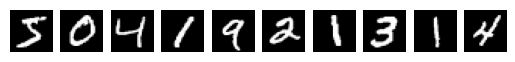

label: [5 0 4 1 9 2 1 3 1 4]


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

num_inst = 10
for i in range(num_inst):
    plt.subplot(1,num_inst,i+1)
    # train_img[i] has shape (28, 28)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:num_inst],))

### Data iterator to iterate raw data by mini-batches

We can train neural network by looking at one image/label at a time, but when there is parallelism from the CPU/GPU hardware,it is far more efficient to look at batches of images at a time.

To iterate images by batches, we can manually write a for loop and partition the data into chunks and look at one chunk at a time. A simpler way is to wrap the raw data using data iterators typically already provided from deep learning frameworks. 

Let's use mx.gluon.data.DataLoader and gluon.data.ArrayDataset to create our data iterators.

Note that there's an option to shuffle the data rows, which is typically done for training data, but not validation/test data.

In [3]:
#!pip install -q mxnet-cu80

In Colab Runtime menu tab, select "Change runtime type" and select GPU for Hardware accelerator.

In [4]:
#!pip install -q mxnet-cu80==1.2.0b20180327

In [5]:
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

def to4d(img):
    """Reshape img to 4d tensor and normalize pixel values to [0, 1]."""
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.gluon.data.DataLoader(gluon.data.ArrayDataset(to4d(train_img), train_lbl), batch_size, shuffle=True)
test_iter = mx.gluon.data.DataLoader(gluon.data.ArrayDataset(to4d(test_img), test_lbl), batch_size)

# DataLoader has a method
# def __iter__(self):
# to see how iterators work, try
# for i, (data, label) in enumerate(train_iter):
#     print(i, data.shape, label.shape)

## Multilayer Perceptron (MLP)

Now, we are ready to create neural models.

One simple model is called multilayer perceptron (MLP).
MLP is made up of several fully-connected layers (or called dense layers) stacked one after another, followed by a softmax layer for label prediction.

A fully-connected layer is an affine transformation taking input tensor *X* to output tensor *Y*, with two parameters, weight *W* and bias *b*.

For the non-batched version, we have the following dimensions for each variable,

\begin{align}
\underset{1xk}{Y} &= \underset{1xm}{x} \underset{mxk}{W} + \underset{1xk}{b}
\end{align}

We usually work with batched version, and it has the following dimensions for each variable,

\begin{align}
\underset{nxk}{Y} &= \underset{nxm}{X} \underset{mxk}{W} + \underset{nxk}{B}
\end{align}

Note that the bias vector is usually specified as a vector 1xk, rather than a full tensor nxk, and relies on array broadcasting to get the right dimension.

The output of a hidden layer is then passed through a non-linear activation layer, e.g., apply sigmoid, tanh or ReLU on output element-wise.

The output of the activation layer can be fed as input to the next fully-connected layer. In this way, we can chain multiple full-connected layer.

Note that if we do not use activation layer, multiple affine transformation is equivalent to a single affine transformation. Activation layer is necessary to add non-linearity.

The last fully-connected layer often has the hidden size equals to the number of classes in the dataset. 
Then we add a softmax layer, which map the input into a probability score.
Assume the input *X* has size *n x m*, the output *Y* would also have size *n x m*, where each row is a normalized probability vector,

$$ \left[\frac{\exp(x_{i1})}{\sum_{j=1}^m \exp(x_{ij})},\ldots, \frac{\exp(x_{im})}{\sum_{j=1}^m \exp(x_{ij})}\right] $$

To evaluate how well the predictions are, we use cross-entropy loss,

\begin{align}
L = \frac{1}{N} \sum y \log{\hat{y}}
\end{align}
where *y* is the one-hot vector of true label, and $\hat{y}$ is the estimated probability from softmax layer.

Here's how we would create a multilayer perceptron in MXNet using Gluon frontend.

In [6]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(128, activation="relu"))
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

# at the end of the 3rd dense layer, there is no activation layer after it
# you can use a softmax layer to make predictions or use a softmax_cross_entropy layer to evaluate loss function
    
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# visualize the network
print(net)

Sequential(
  (0): Dense(None -> 128, Activation(relu))
  (1): Dense(None -> 64, Activation(relu))
  (2): Dense(None -> 10, linear)
)


### Initialize parameters

There are many ways to initialize parameters. For different types of layers, we may need different initialization functions.

Read more about initialization at http://cs231n.github.io/neural-networks-2/#init.

In [7]:
model_ctx = mx.cpu()
# model_ctx = mx.gpu()

net.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)

### Evaluation metric
We can evaluate training/validation set loss by running predictions and compute the average prediction accuracy.

Note that we can extract the predicted label from probability vector with argmax.

In [8]:
def evaluate_accuracy(data_iterator, net):
    """Make predictions for the dataset and evaluate average accuracy."""
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        # reshape to (batch_size, 784)
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        # skipped a softmax layer since it doesn't change predictions
        # use argmax to extract predicted label
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

### Training Loop
Now that both the network definition and data iterators are ready. We can start training. 

We make multiple complete passes over the training data.
Each pass is called an epoch.
In each epoch, we partition the training data to mini-batches.
For each mini-batch, we compute a forward pass of the network to get the predicted output.
Then, we do a backward pass, where we compute the loss function and the gradients of each model parameter.
We then update each model parameter **w** with its gradient multipled by learning rate,

\begin{align}
w = w - \alpha \nabla{w}
\end{align}

In [9]:
# get a optimizer doing SGD with fixed learning rate
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .01})

epochs = 10
smoothing_constant = .01
num_examples = 60000

for e in range(1, epochs+1):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_iter):
        # reshape to (batch_size, 784)
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        # this "with" record allows us to do automatic differentiation
        # basically remembering how the output is compute from the input
        # we can use chain rules to find out the gradients of loss function wrt inputs
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        # compute all gradients
        loss.backward()
        # Perform the weight update.
        # Trainer needs to know the batch size of data to normalize the gradients by 1/batch_size.
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_iter, net)
    train_accuracy = evaluate_accuracy(train_iter, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

[12:53:49] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8904 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Epoch 1. Loss: 1.274676794052124, Train_acc 0.8298166666666666, Test_acc 0.835
Epoch 2. Loss: 0.5153365670839946, Train_acc 0.8748333333333334, Test_acc 0.8802
Epoch 3. Loss: 0.4045152560551961, Train_acc 0.8933, Test_acc 0.8979
Epoch 4. Loss: 0.35663484121958416, Train_acc 0.903, Test_acc 0.9089
Epoch 5. Loss: 0.3266846092859904, Train_acc 0.9091, Test_acc 0.9136
Epoch 6. Loss: 0.3039308423519135, Train_acc 0.9158666666666667, Test_acc 0.9199
Epoch 7. Loss: 0.28589811232884726, Train_acc 0.9204333333333333, Test_acc 0.9253
Epoch 8. Loss: 0.27104150257110593, Train_acc 0.9245333333333333, Test_acc 0.9292
Epoch 9. Loss: 0.25760475850105286, Train_acc 0.9275, Test_acc 0.9297
Epoch 10. Loss: 0.2458699157635371, Train_acc 0.93065, Test_acc 0.9342


### Inference.

After training is done, we can make prediction on test images. 

Let's try it for a single image.

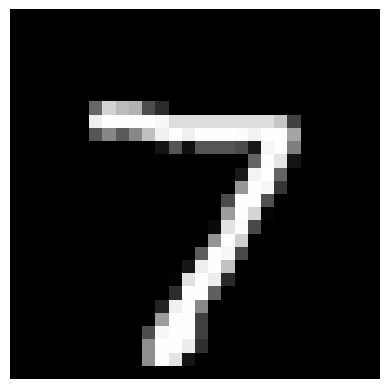

Predicted digit is 7


In [10]:
# show test image
plt.imshow(test_img[0], cmap='Greys_r')
plt.axis('off')
plt.show()

# make prediction
img = nd.array(to4d(test_img[0:1]).reshape((-1, 784)), ctx=model_ctx)
output = net(img)
print("Predicted digit is", nd.argmax(output, axis=1).asnumpy().astype(np.int8)[0])

## Convolutional Neural Networks (ConvNets)

ConvNets is a neural architecture that has a reduced model parameter size compared to MLP, and has been shown to achieve higher accuracy on many vision datasets.

ConvNets introduces two additional layers, the convolution layer and max-pooling layers, on top of fully-connected layers.

Note that the previous fully-connected layer simply flattens the image to a vector, with input dimension (batch_size, 784).
It ignores the spatial locality information for pixels near each other.

The newly introduced convolutional layer aims to leverage the spatial locality by doing a convolution operation on the input image. 
The convolution operation can be visualized as follows.

<img src="https://thatindiandude.github.io/images/conv.png" style="height: 75%; width: 75%;">

The convolution is specified by kernel width, kernel height, num_channel, stride and padding.
Note that the num_channel has to be the same as the num_channel dimension of the input image.

We can also have multiple feature maps, each with their own weight matrices, to capture different features: 
<img src="https://thatindiandude.github.io/images/filters.png" style="height: 75%; width: 75%;">

Besides the convolutional layer, another major innovation of ConvNets is the addition of pooling layers.
A pooling layer reduce a $n\times m$ (often called kernal size) image patch into a single value to make the network less sensitive to the spatial location.

<img src="https://thatindiandude.github.io/images/pooling.png" style="height: 75%; width: 75%;">

In [11]:
num_fc = 512
num_outputs = 10
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(num_fc, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
print(net)

Sequential(
  (0): Conv2D(None -> 20, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (2): Conv2D(None -> 50, kernel_size=(5, 5), stride=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Flatten
  (5): Dense(None -> 512, Activation(relu))
  (6): Dense(None -> 10, linear)
)


Note that LeNet is more complex than the previous multilayer perceptron, so we use GPU instead of CPU for training. 

In [12]:
model_ctx = mx.gpu()

Don't forget to initialize the model again. This time is a different initialization technique.

In [13]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=model_ctx)

The usual training loop. Note that the raw image data is now fed as a 4d tensor to conv layer.

In [14]:
def evaluate_accuracy(data_iterator, net):
    """Make predictions for the dataset and evaluate average accuracy."""
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        # ==== note the difference in raw data input shape ====
        # use 4d tensor (batch_size, 1, 28, 28)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .01})

epochs = 10
smoothing_constant = .01
num_examples = 60000

for e in range(1, epochs+1):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_iter):
        # ==== note the difference in raw data input shape ====
        # use 4d tensor (batch_size, 1, 28, 28)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_iter, net)
    train_accuracy = evaluate_accuracy(train_iter, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

[12:54:15] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Epoch 1. Loss: 1.1135810001691182, Train_acc 0.9030333333333334, Test_acc 0.9052
Epoch 2. Loss: 0.2738972073952357, Train_acc 0.9349333333333333, Test_acc 0.9401
Epoch 3. Loss: 0.18568803434371947, Train_acc 0.9532666666666667, Test_acc 0.958
Epoch 4. Loss: 0.14398082388242087, Train_acc 0.9639, Test_acc 0.9662
Epoch 5. Loss: 0.11799609728256862, Train_acc 0.9630666666666666, Test_acc 0.9676
Epoch 6. Loss: 0.10153435288667678, Train_acc 0.9738, Test_acc 0.9766
Epoch 7. Loss: 0.08984460673332215, Train_acc 0.9755666666666667, Test_acc 0.9785
Epoch 8. Loss: 0.0810748798718055, Train_acc 0.9771833333333333, Test_acc 0.9775
Epoch 9. Loss: 0.07381424021522204, Train_acc 0.9770666666666666, Test_acc 0.9781
Epoch 10. Loss: 0.06782159671584766, Train_acc 0.9803, Test_acc 0.9812


You should see that ConvNets achieve a higher accuracy than MLP.